# Bayesian Information Criterion (BIC) Calculation Using Extreme Deconvolution (XD) (Bovy et al. 2011)

When using, please cite Buckley et al. 2024 (https://doi.org/10.1093/mnras/stae2202).

This notebook calculates the Bayesian Information Criterion (BIC) for a mock dataset generated using a Gaussian Mixture Model (GMM). The workflow includes:
1. Extracting data points and errors from a CSV file.
2. Standardising the data for better numerical stability.
3. Using a Gaussian Mixture Model (GMM) to initialise parameters for Extreme Deconvolution (XD).
4. Performing XD to compute the average log-likelihood for various numbers of components.
5. Calculating BIC scores for each model and visualising the results to determine the optimal number of components.

## Importing Modules

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from extreme_deconvolution import extreme_deconvolution
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

## Extracting Data from the CSV File

This block reads the dataset from a CSV file and extracts:
1. Data points (`X`).
2. Errors (`errors`) associated with the data points.
3. Component labels (`labels`) for reference (not used in XD).

Modify the `filename` variable to specify a different input file.

In [27]:
filename = "generated_data_with_errors.csv" # Path to the input file
data = pd.read_csv(filename)

# Extract dimensions, errors, and labels
num_dimensions = len([col for col in data.columns if col.startswith("Dimension")]) # Number of dimensions
X = data[[f"Dimension_{i+1}" for i in range(num_dimensions)]].values  # Data points
errors = data[[f"Error_Dimension_{i+1}" for i in range(num_dimensions)]].values  # Errors
labels = data["Component_Label"].values  # Component labels (optional)

# Display dataset properties
print(f"Data shape: {X.shape}")
print(f"Errors shape: {errors.shape}")
print(f"Number of dimensions: {num_dimensions}")

Data shape: (10000, 2)
Errors shape: (10000, 2)
Number of dimensions: 2


## Define Bayesian Information Criterion (BIC) Function

This function computes the BIC score for a given model using:
1. Total log-likelihood (`log_likelihood`).
2. Number of free parameters in the model (`num_parameters`).
3. Number of observations (`num_samples`).

The BIC formula penalises models with excessive complexity to avoid overfitting.

In [28]:
def BIC(log_likelihood, num_parameters, num_samples):

    """
    Compute the Bayesian Information Criterion (BIC).
    
    Parameters:
        log_likelihood (float): Total log-likelihood of the model.
        num_parameters (int): Number of free parameters in the model.
        num_observations (int): Number of observations.
        
    Returns:
        float: BIC score.
    """
    
    return -2 * log_likelihood + num_parameters * np.log(num_samples)

## Initialise Variables

This block initialises:
1. The range of components to test (`num_components`).
2. The total number of data points (`num_samples`).
3. The dimensionality of the data (`num_dim`).

These variables are used to calculate the BIC scores for models with different numbers of components.

In [29]:
num_components = np.arange(1, 21)  # Range of components to test
num_samples = len(X)  # Number of data points
num_dim = X.shape[1]  # Number of dimensions

# Display basic information about the dataset
print('The number of dimensions:', num_dim)
print('The number of samples:', num_samples)
print('The number of components:', int(labels[-1] + 1)) # Reference only

The number of dimensions: 2
The number of samples: 10000
The number of components: 3


## Calculate BIC Scores for Different Models

This block performs the following steps:
1. Standardises the data (`X`) and scales the errors for numerical stability.
2. Uses GMM to initialise parameters for XD (weights, means, covariances).
3. Computes the log-likelihood using XD for models with different numbers of components.
4. Calculates the BIC score for each model and stores the results.

In [30]:
# Standardise the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Scale the errors
errors_scaled = errors / scaler.scale_

# Store BIC scores
BIC_scores = []

for n in num_components:
    # Fit a GMM to initialize parameters using standardised data
    gmm = GaussianMixture(n_components=n, random_state=42, covariance_type='full')
    gmm.fit(X_scaled)  # Fit GMM to the scaled data

    # Extract initial parameters from the GMM
    initamp = gmm.weights_  # Component weights
    initmean = gmm.means_   # Component means
    initcovar = gmm.covariances_  # Component covariance matrices

    # Perform Extreme Deconvolution
    try:
        XD_avg_LL = extreme_deconvolution(
            X_scaled, errors_scaled, initamp, initmean, initcovar
        )
        print(f"{n} components fitted with average log-likelihood: {XD_avg_LL}")
    except Exception as e:
        print(f"XD failed for {n} components: {e}")
        continue

    # Compute total log-likelihood
    LL = XD_avg_LL * num_samples

    # Formula for number of free parameters
    num_parameters = n * (1 + num_dim + num_dim * (num_dim + 1) // 2) - 1

    # Calculate BIC
    bic_value = BIC(LL, num_parameters, num_samples)
    BIC_scores.append(bic_value)

1 components fitted with average log-likelihood: -2.807535053115218
2 components fitted with average log-likelihood: -2.7648496285930677
3 components fitted with average log-likelihood: -2.7596511635575633
4 components fitted with average log-likelihood: -2.759196237774771
5 components fitted with average log-likelihood: -2.758600603127713
6 components fitted with average log-likelihood: -2.75851236926823
7 components fitted with average log-likelihood: -2.7582356197821496
8 components fitted with average log-likelihood: -2.7937405084814015
9 components fitted with average log-likelihood: -3.0836974288826355
10 components fitted with average log-likelihood: -3.666145920392594
11 components fitted with average log-likelihood: -3.6119739578655876
12 components fitted with average log-likelihood: -4.009895607161677
13 components fitted with average log-likelihood: -4.181667871635192
14 components fitted with average log-likelihood: -4.163352532726486
15 components fitted with average log-

## Visualise the BIC Scores

This block plots the BIC scores against the number of components to identify the optimal number of components. The "elbow" or minimum point of the curve represents the best-fitting model.

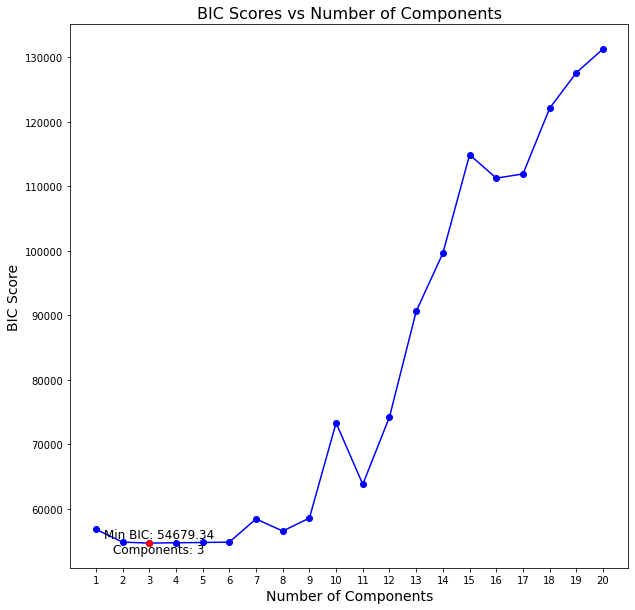

In [25]:
# Plot the BIC scores
plt.figure(figsize=(10, 10))
plt.plot(num_components, BIC_scores, marker='o', color='blue')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('BIC Score', fontsize=14)
plt.title('BIC Scores vs Number of Components', fontsize=16)
plt.xticks(ticks=np.arange(min(num_components), max(num_components) + 1, step=1))

# Highlight the minimum BIC
min_bic_index = np.argmin(BIC_scores)
plt.scatter(num_components[min_bic_index], BIC_scores[min_bic_index], color='red', zorder=5)
plt.annotate(f"Min BIC: {BIC_scores[min_bic_index]:.2f}\nComponents: {num_components[min_bic_index]}", 
             (num_components[min_bic_index], BIC_scores[min_bic_index]),
             textcoords="offset points", xytext=(10, -10), ha='center', fontsize=12)

plt.show()